# Train a PPO Agent to obtain the offline trajectory as input for Decision Transformer

In [1]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

check_and_make_directories([TRAINED_MODEL_DIR])

## Load the train data

In [2]:
train = pd.read_csv('train_data.csv')
# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following two lines.
train = train.set_index(train.columns[0])
train.index.names = ['']

## Define the trajectory collection callback

In [ ]:
import pandas as pd
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class TrajectoryCollectorCallback(BaseCallback):
    """
    A custom callback to collect trajectories (s, a, r) during training.
    """
    def __init__(self, verbose=0):
        super(TrajectoryCollectorCallback, self).__init__(verbose)
        self.states = []
        self.actions = []
        self.rewards = []
        self.episode_starts = []
        
    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to env.step().

        For child callback (of an EvalCallback), this is called
        when the model is evaluated.
        """
        action = self.locals['actions']
        reward = self.locals['rewards'][0]
        state = self.locals['new_obs']
        done = self.locals['dones'][0]

        if isinstance(state, dict):
            state = state['obs'].flatten()
        
        self.states.append(state.flatten())
        self.actions.append(action.flatten())
        self.rewards.append(reward)
        # Record the start of a new episode
        self.episode_starts.append(done)

        return True # Continue training

    def get_trajectories(self) -> pd.DataFrame:
        """
        Returns the collected trajectories as a pandas DataFrame.
        """
        episode_starts_df = [True] + self.episode_starts[:-1]

        return pd.DataFrame({
            'state': self.states,
            'action': self.actions,
            'reward': self.rewards,
            'episode_start': episode_starts_df
        })

## Set up Environment for Training

In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

env_train = StockTradingEnv(df=train, **env_kwargs)

Stock Dimension: 29, State Space: 291


## Train a PPO Agent

In [ ]:
from stable_baselines3 import PPO

agent = DRLAgent(env=env_train)
ppo_params = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
    "gamma": 0.99,
}

ppo_model = PPO(
    policy='MlpPolicy',
    env=env_train,
    tensorboard_log=f"runs/ppo_model",
    verbose=0,
    **ppo_params
)

trajectory_collector = TrajectoryCollectorCallback()


In [17]:
print("Training PPO agent and collecting trajectories...")
ppo_model.learn(
    total_timesteps=200000,
    callback=trajectory_collector
)
print("Training finished.")

# Retrieve the collected data from the callback
offline_dataset = trajectory_collector.get_trajectories()

Training PPO agent and collecting trajectories...
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5131257.19
total_reward: 4131257.19
total_cost: 283410.98
total_trades: 78849
Sharpe: 0.917
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4460729.22
total_reward: 3460729.22
total_cost: 296398.49
total_trades: 78848
Sharpe: 0.852
day: 2892, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 4055305.01
total_reward: 3055305.01
total_cost: 300235.97
total_trades: 77887
Sharpe: 0.789
day: 2892, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 6112577.63
total_reward: 5112577.63
total_cost: 268966.65
total_trades: 76676
Sharpe: 0.940
day: 2892, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 6324730.17
total_reward: 5324730.17
total_cost: 246263.17
total_trades: 74901
Sharpe: 0.992
day: 2892, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 8361144.04
total_reward: 7361144.04
total_cost: 143329.93
total_trades

In [18]:
# Save the dataset to a file
output_path = "ppo_offline_dataset.csv"
offline_dataset.to_csv(output_path, index=False)

print(f"Offline dataset saved to {output_path}")
print("Dataset preview:")
print(offline_dataset.head())

Offline dataset saved to ppo_offline_dataset.csv
Dataset preview:
                                               state  \
0  [983238.9, 2.842525, 41.24785, 15.36934, 34.63...   
1  [965333.94, 2.7956412, 40.341972, 16.23218, 34...   
2  [955755.2, 2.7352316, 40.24518, 15.548393, 33....   
3  [948263.75, 2.7860231, 40.978157, 15.571697, 3...   
4  [947748.44, 2.7223086, 39.954746, 14.94231, 33...   

                                              action    reward  episode_start  
0  [0.57869077, -0.52688104, -0.8708714, 0.215194... -0.004265           True  
1  [-0.017634846, -0.03355947, -0.34992832, 0.409...  0.021079          False  
2  [0.4372227, -2.0030851, 1.7375387, 0.5741014, ... -0.141990          False  
3  [0.6486472, -0.12144503, -2.096453, 0.24912593...  0.001847          False  
4  [-1.5946273, 0.051750872, -1.211483, -0.906264... -0.086285          False  


## Calculate return-to-go

In [ ]:
def calculate_returns_to_go(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates the return-to-go for each step in each episode."""
    df['return_to_go'] = 0
    
    # Group by episodes using the 'episode_start' flag
    episode_indices = df.index[df['episode_start']].tolist()
    
    for i in range(len(episode_indices)):
        start_index = episode_indices[i]
        end_index = episode_indices[i+1] if i + 1 < len(episode_indices) else len(df)
        
        episode_rewards = df.loc[start_index:end_index-1, 'reward'].values
        
        # Calculate RTG: sum of future rewards
        rtg = np.cumsum(episode_rewards[::-1])[::-1]
        df.loc[start_index:end_index-1, 'return_to_go'] = rtg
        
    return df

offline_dataset_with_rtg = calculate_returns_to_go(offline_dataset)

# Save the final dataset ready for the Decision Transformer
offline_dataset_with_rtg.to_csv("decision_transformer_ready_dataset.csv", index=False)
print("\nDataset with returns-to-go calculated:")
print(offline_dataset_with_rtg.head())

/tmp/ipykernel_2337038/2333506160.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[232.03456   232.03882   232.01775   ...  12.897934    7.587329
   3.7936645]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[start_index:end_index-1, 'return_to_go'] = rtg



Dataset with returns-to-go calculated:
                                               state  \
0  [983238.9, 2.842525, 41.24785, 15.36934, 34.63...   
1  [965333.94, 2.7956412, 40.341972, 16.23218, 34...   
2  [955755.2, 2.7352316, 40.24518, 15.548393, 33....   
3  [948263.75, 2.7860231, 40.978157, 15.571697, 3...   
4  [947748.44, 2.7223086, 39.954746, 14.94231, 33...   

                                              action    reward  episode_start  \
0  [0.57869077, -0.52688104, -0.8708714, 0.215194... -0.004265           True   
1  [-0.017634846, -0.03355947, -0.34992832, 0.409...  0.021079          False   
2  [0.4372227, -2.0030851, 1.7375387, 0.5741014, ... -0.141990          False   
3  [0.6486472, -0.12144503, -2.096453, 0.24912593...  0.001847          False   
4  [-1.5946273, 0.051750872, -1.211483, -0.906264... -0.086285          False   

   return_to_go  
0    232.034561  
1    232.038818  
2    232.017746  
3    232.159729  
4    232.157883  


In [36]:
print(offline_dataset_with_rtg.shape)

(200704, 5)


### Check the number of episodes

In [28]:
offline_dataset_with_rtg[offline_dataset_with_rtg["episode_start"] == True]

,state,action,reward,episode_start,return_to_go
0,"[983238.9, 2.842525, 41.24785, 15.36934, 34.63...","[0.57869077, -0.52688104, -0.8708714, 0.215194...",-0.004265,True,232.034561
2893,"[973397.4, 2.842525, 41.24785, 15.36934, 34.63...","[1.4011476, 0.084764585, 0.5821775, 1.3766154,...",0.001266,True,234.636032
5786,"[978545.44, 2.842525, 41.24785, 15.36934, 34.6...","[-1.435055, -2.8120008, -0.9220194, -0.0747443...",-0.018742,True,221.613739
8679,"[984720.8, 2.842525, 41.24785, 15.36934, 34.63...","[-0.5364404, -0.9787629, -0.75075907, 0.174425...",-0.010858,True,235.141342
11572,"[972399.9, 2.842525, 41.24785, 15.36934, 34.63...","[-0.27394363, -0.11478643, -0.19372419, -1.564...",-0.016795,True,316.139557
...,...,...,...,...,...
188045,"[964490.8, 2.842525, 41.24785, 15.36934, 34.63...","[1.09352, 1.9732546, -1.8541753, 1.7613653, 1....",0.003325,True,651.334229
190938,"[977204.56, 2.842525, 41.24785, 15.36934, 34.6...","[0.8658338, 0.33795804, -0.43245977, -0.645624...",-0.013000,True,629.148315
193831,"[984274.94, 2.842525, 41.24785, 15.36934, 34.6...","[-1.1216424, -1.9519029, -0.2321325, -0.443385...",-0.020057,True,630.301392
196724,"[975651.1, 2.842525, 41.24785, 15.36934, 34.63...","[0.012762435, 0.45691967, -0.6252167, 0.195188...",-0.017901,True,649.779358


## Plot the return-to-go and rewards for a simple episode


Plot for Episode 60 saved as 'episode_60_plot.png'


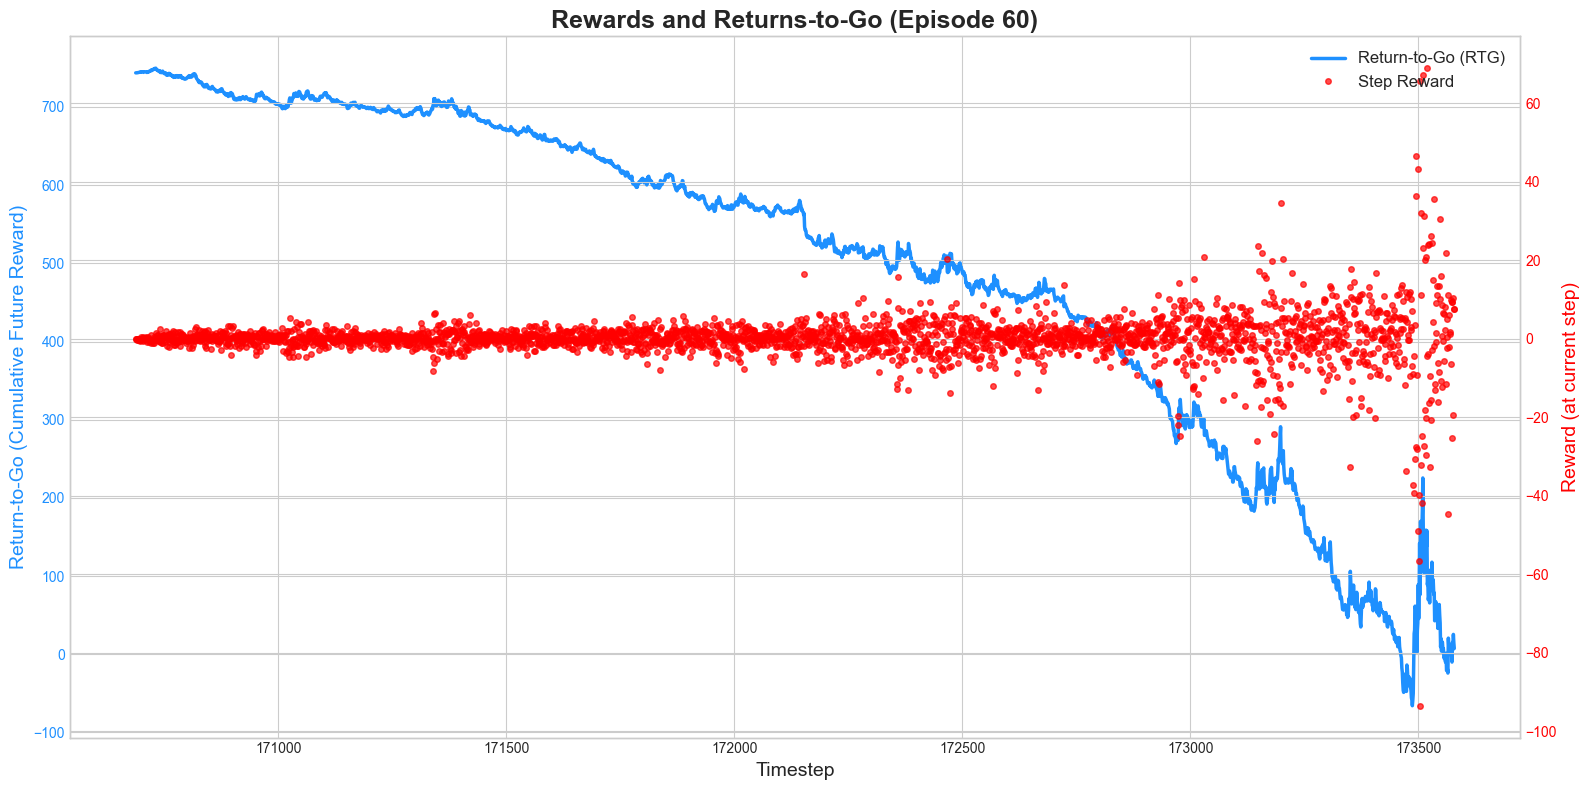

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df = pd.read_csv("decision_transformer_ready_dataset.csv")

# Get the start index of all episodes
episode_starts = df.index[df['episode_start']].tolist()
EPISODE_TO_PLOT = 60
if EPISODE_TO_PLOT > len(episode_starts) or EPISODE_TO_PLOT <= 0:
    print(f"Error: Episode {EPISODE_TO_PLOT} is out of range. "
          f"Please choose a number between 1 and {len(episode_starts)}.")
else:
    # Get the start and end index for the chosen episode
    start_index = episode_starts[EPISODE_TO_PLOT - 1]
    # The end index is the start of the next episode, or the end of the dataframe
    end_index = episode_starts[EPISODE_TO_PLOT] if EPISODE_TO_PLOT < len(episode_starts) else len(df)
    
    # Slice the dataframe to get only the data for the selected episode
    plot_df = df.iloc[start_index:end_index]

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plotting the Return-to-Go
    ax.plot(plot_df.index, plot_df['return_to_go'], color='dodgerblue', lw=2.5, label='Return-to-Go (RTG)')

    # Plotting the individual Rewards on a secondary y-axis
    ax2 = ax.twinx()
    ax2.plot(plot_df.index, plot_df['reward'], color='red', alpha=0.7, linestyle='', marker='o', markersize=4, label='Step Reward')

    ax.set_title(f'Rewards and Returns-to-Go (Episode {EPISODE_TO_PLOT})', fontsize=18, fontweight='bold')
    ax.set_xlabel('Timestep', fontsize=14)
    ax.set_ylabel('Return-to-Go (Cumulative Future Reward)', fontsize=14, color='dodgerblue')
    ax2.set_ylabel('Reward (at current step)', fontsize=14, color='red')
    ax.tick_params(axis='y', labelcolor='dodgerblue')
    ax2.tick_params(axis='y', labelcolor='red')

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right', fontsize=12)

    fig.tight_layout()
    plt.savefig(f'episode_{EPISODE_TO_PLOT}_plot.png', dpi=300)
    print(f"\nPlot for Episode {EPISODE_TO_PLOT} saved as 'episode_{EPISODE_TO_PLOT}_plot.png'")
    plt.show()